In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_8")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from s8_utils import load_cifar10_data, preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from s8_model import Model_Net, model_summary, model_train, model_test

Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cifar_10_model = Model_Net(norm_type = 'group_norm', num_groups = 2).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
         GroupNorm-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             256
        GroupNorm-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1

/content/ERA_V1/session_8/s8_model.py:199: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomResizedCrop(size=(32, 32),antialias=True),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])

Download Data

In [5]:
train_data, test_data, class_names = load_cifar10_data(train_transforms, test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Define train and test loaders

In [6]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, **kwargs)

Calculate Mean and Std of dataset

In [7]:
from tqdm import tqdm
import numpy as np
mean_r = 0
mean_g = 0
mean_b = 0

std_r = 0
std_g = 0
std_b = 0
loader_for_stats = test_loader
for img,_ in tqdm(loader_for_stats):
    img = np.asarray(img)
    # calculate Mean of Normalized dataset
    mean_r += np.mean(img[:,0,:,:])
    mean_g += np.mean(img[:,1,:,:])
    mean_b += np.mean(img[:,2,:,:])
    # calculate std of Normalized dataset
    std_r += np.var(img[:,0,:,:])
    std_g += np.var(img[:,1,:,:])
    std_b += np.var(img[:,2,:,:])
mean_r = mean_r / len(loader_for_stats)
mean_g = mean_g / len(loader_for_stats)
mean_b = mean_b / len(loader_for_stats)
std_r = np.sqrt(((1./(len(loader_for_stats)-1))*std_r))
std_g = np.sqrt(((1./(len(loader_for_stats)-1))*std_g))
std_b = np.sqrt(((1./(len(loader_for_stats)-1))*std_b))
print(f"dataset mean: {mean_r:0.3f}, {mean_g:0.3f}, {mean_b:0.3f}")
print(f"dataset std: {std_r:0.3f}, {std_g:0.3f}, {std_b:0.3f}")


100%|██████████| 79/79 [00:05<00:00, 13.96it/s]

dataset mean: 0.013, 0.014, 0.015
dataset std: 1.005, 1.002, 1.004


Show sample Images

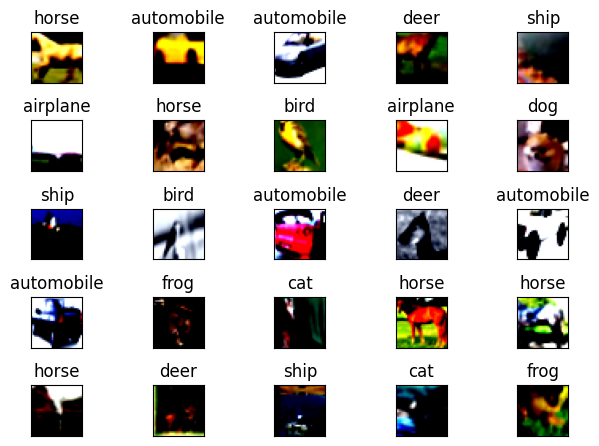

In [8]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [9]:
model_bn = Model_Net(norm_type='batch_norm').to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    #scheduler.step()
    #print(optimizer.)
target_test_acc = 70.
#plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
#incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)


epoch: 1


loss=1.7051082849502563 batch_id=390 Accuracy = 30.12: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]



Test set: Average loss: 1.5965, Accuracy: 3950/10000 (39.50%)

epoch: 2


loss=1.6042181253433228 batch_id=390 Accuracy = 41.27: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]



Test set: Average loss: 1.5713, Accuracy: 4361/10000 (43.61%)

epoch: 3


loss=1.7360528707504272 batch_id=390 Accuracy = 45.72: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]



Test set: Average loss: 1.3431, Accuracy: 5234/10000 (52.34%)

epoch: 4


loss=1.38191819190979 batch_id=390 Accuracy = 48.99: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s]



Test set: Average loss: 1.1859, Accuracy: 5738/10000 (57.38%)

epoch: 5


loss=1.4579508304595947 batch_id=390 Accuracy = 51.36: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s]



Test set: Average loss: 1.3182, Accuracy: 5332/10000 (53.32%)

epoch: 6


loss=1.2127187252044678 batch_id=390 Accuracy = 52.63: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]



Test set: Average loss: 1.1855, Accuracy: 5762/10000 (57.62%)

epoch: 7


loss=1.2246122360229492 batch_id=390 Accuracy = 53.80: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]



Test set: Average loss: 1.1394, Accuracy: 5946/10000 (59.46%)

epoch: 8


loss=1.348368763923645 batch_id=390 Accuracy = 54.98: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]



Test set: Average loss: 1.1285, Accuracy: 5987/10000 (59.87%)

epoch: 9


loss=1.4522899389266968 batch_id=390 Accuracy = 55.82: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]



Test set: Average loss: 1.3491, Accuracy: 5404/10000 (54.04%)

epoch: 10


loss=1.0893617868423462 batch_id=390 Accuracy = 56.83: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]



Test set: Average loss: 1.0328, Accuracy: 6368/10000 (63.68%)

epoch: 11


loss=1.129638671875 batch_id=390 Accuracy = 57.51: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]



Test set: Average loss: 0.9906, Accuracy: 6560/10000 (65.60%)

epoch: 12


loss=1.1120285987854004 batch_id=390 Accuracy = 58.32: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s]



Test set: Average loss: 1.1428, Accuracy: 6103/10000 (61.03%)

epoch: 13


loss=1.0376092195510864 batch_id=390 Accuracy = 58.71: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]



Test set: Average loss: 0.9978, Accuracy: 6489/10000 (64.89%)

epoch: 14


loss=1.1370338201522827 batch_id=390 Accuracy = 59.69: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]



Test set: Average loss: 0.9262, Accuracy: 6786/10000 (67.86%)

epoch: 15


loss=1.0757882595062256 batch_id=390 Accuracy = 59.71: 100%|██████████| 391/391 [00:29<00:00, 13.41it/s]



Test set: Average loss: 0.9112, Accuracy: 6776/10000 (67.76%)

epoch: 16


loss=1.3686985969543457 batch_id=390 Accuracy = 60.41: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]



Test set: Average loss: 0.9477, Accuracy: 6698/10000 (66.98%)

epoch: 17


loss=0.9773748517036438 batch_id=390 Accuracy = 60.76: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]



Test set: Average loss: 0.9950, Accuracy: 6610/10000 (66.10%)

epoch: 18


loss=1.1075856685638428 batch_id=390 Accuracy = 60.77: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]



Test set: Average loss: 0.8604, Accuracy: 6940/10000 (69.40%)

epoch: 19


loss=1.111074686050415 batch_id=390 Accuracy = 61.66: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]



Test set: Average loss: 0.8755, Accuracy: 7008/10000 (70.08%)



Plot results for Batch Norm experiment

In [10]:
#plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
#incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Train Model using Layer Normalization

In [12]:
model_ln = Model_Net(norm_type='layer_norm').to(device)
optimizer_ln = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
scheduler_ln = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ln, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
train_losses_ln = []
test_losses_ln = []
train_acc_ln = []
test_acc_ln = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_ln, device, train_loader, optimizer_ln, train_acc_ln, train_losses_ln)
    this_loss = model_test(model_ln, device, test_loader, test_acc_ln, test_losses_ln)
    scheduler_ln.step(this_loss)
    #print(optimizer.)
target_test_acc = 70.



epoch: 1


  0%|          | 0/391 [00:00<?, ?it/s]/content/ERA_V1/session_8/s8_model.py:199: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=1.9921334981918335 batch_id=390 Accuracy = 19.49: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s]



Test set: Average loss: 1.9148, Accuracy: 2729/10000 (27.29%)

epoch: 2


loss=1.7878472805023193 batch_id=390 Accuracy = 26.39: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]



Test set: Average loss: 1.8013, Accuracy: 3299/10000 (32.99%)

epoch: 3


loss=1.9461052417755127 batch_id=390 Accuracy = 30.27: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]



Test set: Average loss: 1.8136, Accuracy: 3440/10000 (34.40%)

epoch: 4


loss=1.6992042064666748 batch_id=390 Accuracy = 33.27: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]



Test set: Average loss: 1.6306, Accuracy: 3940/10000 (39.40%)

epoch: 5


loss=1.5836645364761353 batch_id=390 Accuracy = 36.48: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]



Test set: Average loss: 1.5338, Accuracy: 4450/10000 (44.50%)

epoch: 6


loss=1.713104009628296 batch_id=390 Accuracy = 37.98: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s]



Test set: Average loss: 1.5850, Accuracy: 4220/10000 (42.20%)

epoch: 7


loss=1.4579435586929321 batch_id=390 Accuracy = 39.81: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s]



Test set: Average loss: 1.4609, Accuracy: 4819/10000 (48.19%)

epoch: 8


loss=1.596401333808899 batch_id=390 Accuracy = 41.44: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]



Test set: Average loss: 1.4649, Accuracy: 4668/10000 (46.68%)

epoch: 9


loss=1.7272815704345703 batch_id=390 Accuracy = 42.89: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]



Test set: Average loss: 1.4941, Accuracy: 4625/10000 (46.25%)

epoch: 10


loss=1.517051100730896 batch_id=390 Accuracy = 44.05: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]



Test set: Average loss: 1.3763, Accuracy: 5080/10000 (50.80%)

epoch: 11


loss=1.402143955230713 batch_id=390 Accuracy = 45.45: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]



Test set: Average loss: 1.3600, Accuracy: 5057/10000 (50.57%)

epoch: 12


loss=1.3826035261154175 batch_id=390 Accuracy = 46.27: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s]



Test set: Average loss: 1.3603, Accuracy: 5108/10000 (51.08%)

epoch: 13


loss=1.3546993732452393 batch_id=390 Accuracy = 47.26: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]



Test set: Average loss: 1.3468, Accuracy: 5208/10000 (52.08%)

epoch: 14


loss=1.3087680339813232 batch_id=390 Accuracy = 48.00: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]



Test set: Average loss: 1.2507, Accuracy: 5417/10000 (54.17%)

epoch: 15


loss=1.3852965831756592 batch_id=390 Accuracy = 49.34: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]



Test set: Average loss: 1.2571, Accuracy: 5443/10000 (54.43%)

epoch: 16


loss=1.5119221210479736 batch_id=390 Accuracy = 50.06: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]



Test set: Average loss: 1.3207, Accuracy: 5305/10000 (53.05%)

epoch: 17


loss=1.2571823596954346 batch_id=390 Accuracy = 50.46: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]



Test set: Average loss: 1.1962, Accuracy: 5699/10000 (56.99%)

epoch: 18


loss=1.4258670806884766 batch_id=390 Accuracy = 51.06: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 1.1508, Accuracy: 5903/10000 (59.03%)

epoch: 19


loss=1.2983335256576538 batch_id=390 Accuracy = 51.86: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]



Test set: Average loss: 1.1478, Accuracy: 5987/10000 (59.87%)



Show Results for Layer Norm experiments

In [ ]:
#plot_statistics(train_losses_ln, train_acc_ln, test_losses_ln, test_acc_ln, target_test_acc)
#incorrect_predictions_ln = get_incorrect_predictions(model_ln, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_ln, class_names, num_rows = 2, num_cols = 5)

Train Model using Group Normalization

In [13]:
model_gn = Model_Net(norm_type='group_norm', num_groups=2).to(device)
optimizer_gn = optim.SGD(model_gn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer_gn, step_size=8, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
train_losses_gn = []
test_losses_gn = []
train_acc_gn = []
test_acc_gn = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_gn, device, train_loader, optimizer_gn, train_acc_gn, train_losses_gn)
    this_loss = model_test(model_gn, device, test_loader, test_acc_gn, test_losses_gn)
    scheduler.step()
    #print(optimizer.)
target_test_acc = 70.



Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 1


loss=2.0839619636535645 batch_id=390 Accuracy = 21.61: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]



Test set: Average loss: 1.9010, Accuracy: 2800/10000 (28.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 2


loss=1.7534258365631104 batch_id=390 Accuracy = 28.01: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]



Test set: Average loss: 1.7356, Accuracy: 3451/10000 (34.51%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 3


loss=1.7855217456817627 batch_id=390 Accuracy = 32.06: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]



Test set: Average loss: 1.6581, Accuracy: 3877/10000 (38.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 4


loss=1.7907207012176514 batch_id=390 Accuracy = 35.74: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]



Test set: Average loss: 1.5514, Accuracy: 4330/10000 (43.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 5


loss=1.4373458623886108 batch_id=390 Accuracy = 38.03: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]



Test set: Average loss: 1.4887, Accuracy: 4615/10000 (46.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 6


loss=1.544474720954895 batch_id=390 Accuracy = 40.55: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]



Test set: Average loss: 1.4767, Accuracy: 4606/10000 (46.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 7


loss=1.4477465152740479 batch_id=390 Accuracy = 42.27: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s]



Test set: Average loss: 1.4358, Accuracy: 4799/10000 (47.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 8


loss=1.5509957075119019 batch_id=390 Accuracy = 43.86: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]



Test set: Average loss: 1.3554, Accuracy: 5042/10000 (50.42%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 9


loss=1.5836584568023682 batch_id=390 Accuracy = 47.83: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]



Test set: Average loss: 1.3003, Accuracy: 5287/10000 (52.87%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 10


loss=1.576680302619934 batch_id=390 Accuracy = 48.25: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s]



Test set: Average loss: 1.2999, Accuracy: 5339/10000 (53.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 11


loss=1.399278163909912 batch_id=390 Accuracy = 48.60: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]



Test set: Average loss: 1.3100, Accuracy: 5247/10000 (52.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 12


loss=1.4023984670639038 batch_id=390 Accuracy = 48.75: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s]



Test set: Average loss: 1.2768, Accuracy: 5380/10000 (53.80%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 13


loss=1.4140663146972656 batch_id=390 Accuracy = 48.92: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]



Test set: Average loss: 1.2744, Accuracy: 5370/10000 (53.70%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 14


loss=1.505662202835083 batch_id=390 Accuracy = 49.31: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]



Test set: Average loss: 1.2512, Accuracy: 5472/10000 (54.72%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 15


loss=1.3657993078231812 batch_id=390 Accuracy = 49.95: 100%|██████████| 391/391 [00:29<00:00, 13.05it/s]



Test set: Average loss: 1.2411, Accuracy: 5493/10000 (54.93%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 16


loss=1.2481906414031982 batch_id=390 Accuracy = 49.86: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]



Test set: Average loss: 1.2513, Accuracy: 5475/10000 (54.75%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 17


loss=1.5636119842529297 batch_id=390 Accuracy = 50.66: 100%|██████████| 391/391 [00:30<00:00, 12.97it/s]



Test set: Average loss: 1.2436, Accuracy: 5535/10000 (55.35%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 18


loss=1.356391191482544 batch_id=390 Accuracy = 50.78: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]



Test set: Average loss: 1.2429, Accuracy: 5533/10000 (55.33%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 19


loss=1.4827762842178345 batch_id=390 Accuracy = 50.91: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]



Test set: Average loss: 1.2345, Accuracy: 5563/10000 (55.63%)

Adjusting learning rate of group 0 to 1.0000e-04.


Plot Results for Group Norm

In [ ]:
#plot_statistics(train_losses_gn, train_acc_gn, test_losses_gn, test_acc_gn, target_test_acc)
#incorrect_predictions_ln = get_incorrect_predictions(model_gn, test_loader, device)
#show_incorrect_predictions(incorrect_predictions_gn, class_names, num_rows = 2, num_cols = 5)